# Imports and Functions

In [23]:
from ml_experiments.utils import unflatten_dict, update_recursively
from cohirf.models.cohirf import ModularCoHiRF, CoHiRF, BaseCoHiRF
from cohirf.models.batch_cohirf import BatchCoHiRF
from cohirf.models.kernel_kmeans import KernelKMeans
from cohirf.models.pseudo_kernel import PseudoKernelClustering
from cohirf.models.lazy_minibatchkmeans import LazyMiniBatchKMeans
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask_ml.datasets import make_blobs as dask_make_blobs
from dask_ml.preprocessing import StandardScaler as DaskStandardScaler
from cohirf.metrics import adjusted_rand_score as dask_adjusted_rand_score
import dask.array as da

# Dataset (easy)

In [26]:
random_state_dataset = 42
n_samples = int(1e5)
n_features = 10
n_clusters = 5
distance = 5
cluster_std = 1
rng = np.random.default_rng(random_state_dataset)
# Generate equally spaced centers using a regular simplex
# Start with a random orthonormal basis in P dimensions
centers = rng.standard_normal((n_clusters, n_features))
centers, _ = np.linalg.qr(centers.T)  # Orthonormalize columns
centers = centers.T
# Scale the simplex to achieve the desired pairwise distance
centers *= distance / np.sqrt(2)
X, y = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=centers,
    cluster_std=cluster_std,
    random_state=random_state_dataset,
)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# visualize with 2D projection (TSNE)
tsne = TSNE(n_components=2, random_state=random_state_dataset)
sample_size = 1e4
indices = np.random.choice(X.shape[0], size=int(sample_size), replace=False)
X_2d = tsne.fit_transform(X[indices])
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap="viridis", s=10)
ax.set_title("2D Projection of the Dataset")
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
plt.show()

In [4]:
seed = 42
model = CoHiRF(repetitions=3, n_features='full', kmeans_n_clusters=5, random_state=seed)
labels = model.fit_predict(X)
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 0.941


In [8]:
model = BatchCoHiRF(
    batch_size=int(1e4),
    verbose=True,
    cohirf_kwargs=dict(repetitions=3, n_features="full", kmeans_n_clusters=5, random_state=seed),
    n_jobs=-1,
)
labels = model.fit_predict(X)
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Starting epoch 0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Starting epoch 1
Getting labels from parents
Adjusted Rand Index: 0.940


In [9]:
model1 = BatchCoHiRF(
    batch_size=int(1e4),
    verbose=True,
    cohirf_kwargs=dict(repetitions=3, n_features="full", kmeans_n_clusters=5, random_state=seed),
    max_epochs=1,
    n_jobs=-1,
)
model1.fit(X)
representatives_indexes = model1.representatives_indexes_
parents = model1.parents_
model2 = BatchCoHiRF(
    batch_size=int(1e4),
    verbose=True,
    cohirf_kwargs=dict(repetitions=3, n_features="full", kmeans_n_clusters=5, random_state=seed),
    max_epochs=10,
    n_jobs=-1,
)
labels = model2.fit_predict(X, representatives_indexes=representatives_indexes, parents=parents)
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Starting epoch 0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished


Getting labels from parents
Starting epoch 0
Getting labels from parents
Adjusted Rand Index: 0.940


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


In [10]:
model1 = BatchCoHiRF(
    batch_size=int(1e4),
    verbose=True,
    cohirf_kwargs=dict(repetitions=3, n_features="full", kmeans_n_clusters=5, random_state=seed, max_iter=1),
    max_epochs=1,
    n_jobs=-1,
)
model1.fit(X)
representatives_indexes = model1.representatives_indexes_
parents = model1.parents_
model2 = BatchCoHiRF(
    batch_size=int(1e4),
    verbose=True,
    cohirf_kwargs=dict(repetitions=3, n_features="full", kmeans_n_clusters=5, random_state=seed),
    max_epochs=10,
    n_jobs=-1,
)
labels = model2.fit_predict(X, representatives_indexes=representatives_indexes, parents=parents)
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Starting epoch 0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Getting labels from parents
Starting epoch 0
Getting labels from parents
Adjusted Rand Index: 0.940


# Dataset Large

In [2]:
random_state_dataset = 42
n_samples = int(1e7)
n_features = 10
n_clusters = 5
distance = 5
cluster_std = 1
rng = np.random.default_rng(random_state_dataset)
# Generate equally spaced centers using a regular simplex
# Start with a random orthonormal basis in P dimensions
centers = rng.standard_normal((n_clusters, n_features))
centers, _ = np.linalg.qr(centers.T)  # Orthonormalize columns
centers = centers.T
# Scale the simplex to achieve the desired pairwise distance
centers *= distance / np.sqrt(2)
X, y = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=centers,
    cluster_std=cluster_std,
    random_state=random_state_dataset,
)
scaler = StandardScaler()
X = scaler.fit_transform(X)
seed = 42

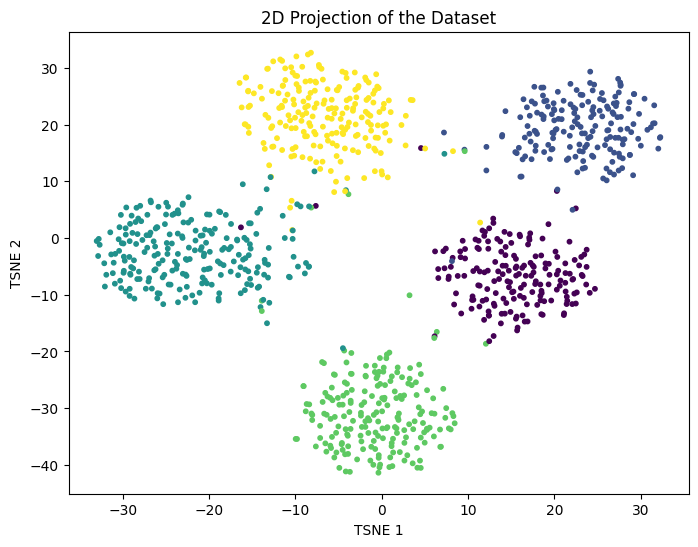

In [3]:
# visualize with 2D projection (TSNE)
tsne = TSNE(n_components=2, random_state=random_state_dataset)
sample_size = 1e3
indices = np.random.choice(X.shape[0], size=int(sample_size), replace=False)
X_2d = tsne.fit_transform(X[indices])
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y[indices], cmap="viridis", s=10)
ax.set_title("2D Projection of the Dataset")
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
plt.show()

In [4]:
model = CoHiRF(
    repetitions=3,
    n_features='full',
    kmeans_n_clusters=5,
    random_state=seed,
    n_samples_representative=1000,
)
labels = model.fit_predict(X)
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 0.941


In [5]:
model = BatchCoHiRF(
    batch_size=int(1e5),
    verbose=True,
    cohirf_kwargs=dict(
        repetitions=3,
        n_features="full",
        kmeans_n_clusters=5,
        random_state=seed,
        n_samples_representative=1000,
        automatically_get_labels=False,
    ),
    n_jobs=5,
)
labels = model.fit_predict(X)
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Starting epoch 0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   13.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   22.4s finished


Starting epoch 1
Getting labels from parents


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Adjusted Rand Index: 0.927


In [11]:
model = BatchCoHiRF(
    batch_size=int(1e4),
    verbose=True,
    cohirf_kwargs=dict(
        repetitions=3,
        n_features="full",
        kmeans_n_clusters=5,
        random_state=seed,
        n_samples_representative=1000,
        automatically_get_labels=False,
    ),
    n_jobs=5,
)
labels = model.fit_predict(X)
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Starting epoch 0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 665 tasks      | elapsed:   15.4s
[Parallel(n_jobs=5)]: Done 991 out of 1000 | elapsed:   23.4s remaining:    0.2s
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:   23.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Starting epoch 1
Getting labels from parents
Adjusted Rand Index: 0.921


In [6]:
model = KMeans(n_clusters=5, random_state=seed)
labels = model.fit_predict(X)
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 0.941


In [7]:
model = MiniBatchKMeans(n_clusters=5, batch_size=int(1e5), random_state=seed)
labels = model.fit_predict(X)
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 0.941


In [9]:
model = BatchCoHiRF(
    batch_size=int(1e5),
    verbose=True,
    cohirf_model=ModularCoHiRF,
    cohirf_kwargs=dict(
        base_model=MiniBatchKMeans,
        base_model_kwargs=dict(n_clusters=5, reassignment_ratio=0, batch_size=int(1e3)),
        repetitions=3,
        n_features="full",
        random_state=seed,
        n_samples_representative=1000,
        automatically_get_labels=False,
    ),
    n_jobs=5,
)
labels = model.fit_predict(X)
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Starting epoch 0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done  91 out of 100 | elapsed:    9.7s remaining:    1.0s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Starting epoch 1
Getting labels from parents
Adjusted Rand Index: 0.757


In [10]:
model = BatchCoHiRF(
    batch_size=int(1e5),
    verbose=True,
    cohirf_model=ModularCoHiRF,
    cohirf_kwargs=dict(
        base_model=KMeans,
        base_model_kwargs=dict(n_clusters=5),
        repetitions=3,
        n_features="full",
        random_state=seed,
        n_samples_representative=1000,
        automatically_get_labels=False,
        max_iter=1,
    ),
    n_jobs=-1,
)
labels = model.fit_predict(X)
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Starting epoch 0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Starting epoch 1
Getting labels from parents
Adjusted Rand Index: 0.941


In [10]:
model1 = BatchCoHiRF(
    batch_size=int(1e5),
    verbose=True,
    cohirf_kwargs=dict(
        repetitions=3,
        n_features="full",
        kmeans_n_clusters=5,
        random_state=seed,
        max_iter=1,
        n_samples_representative=1000,
        automatically_get_labels=False,
    ),
    max_epochs=1,
    n_jobs=-1,
    automatically_get_labels=False,
)
model1.fit(X)
representatives_indexes = model1.representatives_indexes_
parents = model1.parents_
model2 = BatchCoHiRF(
    batch_size=int(1e5),
    verbose=True,
    cohirf_kwargs=dict(
        repetitions=3,
        n_features="full",
        kmeans_n_clusters=5,
        random_state=seed,
        n_samples_representative=1000,
        automatically_get_labels=False,
    ),
    max_epochs=10,
    n_jobs=-1,
)
labels = model2.fit_predict(X, representatives_indexes=representatives_indexes, parents=parents)
ari = adjusted_rand_score(y, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Starting epoch 0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.7s finished


Starting epoch 0
Getting labels from parents


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Adjusted Rand Index: 0.941


# Dataset HUGE

In [1]:
# This does not fit our current memory, we must use dask
# random_state_dataset = 42
# n_samples = int(1e8)
# n_features = 10
# n_clusters = 5
# distance = 5
# cluster_std = 1
# rng = np.random.default_rng(random_state_dataset)
# # Generate equally spaced centers using a regular simplex
# # Start with a random orthonormal basis in P dimensions
# centers = rng.standard_normal((n_clusters, n_features))
# centers, _ = np.linalg.qr(centers.T)  # Orthonormalize columns
# centers = centers.T
# # Scale the simplex to achieve the desired pairwise distance
# centers *= distance / np.sqrt(2)
# X, y = make_blobs(
#     n_samples=n_samples,
#     n_features=n_features,
#     centers=centers,
#     cluster_std=cluster_std,
#     random_state=random_state_dataset,
# )
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
# seed = 42

In [2]:
random_state_dataset = 42
n_samples = int(1e8)
n_features = 10
n_clusters = 5
distance = 5
cluster_std = 1
rng = np.random.default_rng(random_state_dataset)
# Generate equally spaced centers using a regular simplex
# Start with a random orthonormal basis in P dimensions
centers = rng.standard_normal((n_clusters, n_features))
centers, _ = np.linalg.qr(centers.T)  # Orthonormalize columns
centers = centers.T
# Scale the simplex to achieve the desired pairwise distance
centers *= distance / np.sqrt(2)
X, y = dask_make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=centers,
    cluster_std=cluster_std,
    random_state=random_state_dataset,
    chunks=int(1e5)
)
scaler = DaskStandardScaler()
X = scaler.fit_transform(X)
seed = 42

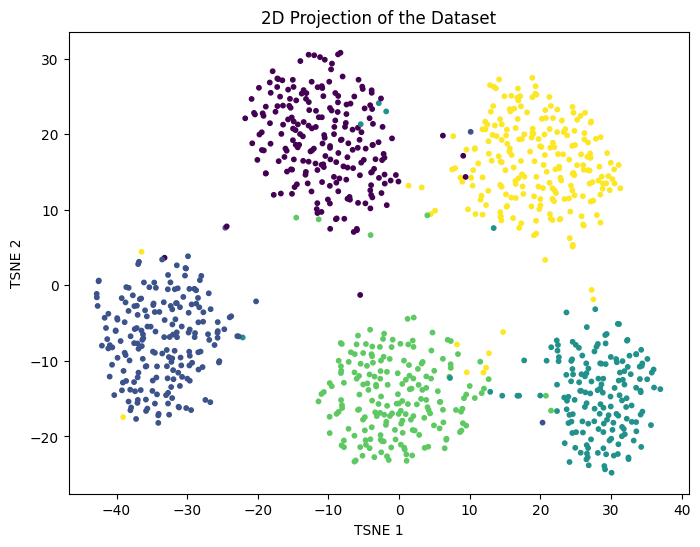

In [3]:
# visualize with 2D projection (TSNE)
tsne = TSNE(n_components=2, random_state=random_state_dataset)
sample_size = 1e3
indices = np.random.choice(X.shape[0], size=int(sample_size), replace=False)
X_2d = tsne.fit_transform(X[indices])
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=y[indices], cmap="viridis", s=10)
ax.set_title("2D Projection of the Dataset")
ax.set_xlabel("TSNE 1")
ax.set_ylabel("TSNE 2")
plt.show()

In [3]:
model = BatchCoHiRF(
    batch_size=int(1e5),
    verbose=True,
    cohirf_model=ModularCoHiRF,
    cohirf_kwargs=dict(
        base_model=KMeans,
        base_model_kwargs=dict(n_clusters=5),
        repetitions=3,
        n_features="full",
        random_state=seed,
        n_samples_representative=1000,
        automatically_get_labels=False,
        # max_iter=1,
    ),
    n_jobs=5,
)
labels = model.fit_predict(X)
dask_labels = da.from_array(labels, chunks=y.chunks)
ari = dask_adjusted_rand_score(y, dask_labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Starting epoch 0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   13.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:  4.2min finished


Starting epoch 1


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Getting labels from parents
Adjusted Rand Index: 0.900


In [6]:
del labels, dask_labels

In [3]:
model = BatchCoHiRF(
    batch_size=int(1e5),
    verbose=True,
    cohirf_model=ModularCoHiRF,
    cohirf_kwargs=dict(
        base_model=KMeans,
        base_model_kwargs=dict(n_clusters=5),
        repetitions=3,
        n_features="full",
        random_state=seed,
        n_samples_representative=1000,
        automatically_get_labels=False,
        max_iter=1,
    ),
    n_jobs=5,
    hierarchy_strategy='labels'
)
labels = model.fit_predict(X)
dask_labels = da.from_array(labels, chunks=y.chunks)
ari = dask_adjusted_rand_score(y, dask_labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Starting epoch 0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    9.5s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   40.0s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 1000 out of 1000 | elapsed:  3.5min finished


Updating labels
Starting epoch 1


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Updating labels
Adjusted Rand Index: 0.941


In [3]:
model1 = BatchCoHiRF(
    batch_size=int(1e5),
    verbose=True,
    cohirf_kwargs=dict(
        repetitions=3,
        n_features="full",
        kmeans_n_clusters=5,
        random_state=seed,
        max_iter=1,
        n_samples_representative=1000,
        automatically_get_labels=False,
    ),
    max_epochs=1,
    n_jobs=-1,
    automatically_get_labels=False,
)
model1.fit(X)
representatives_indexes = model1.representatives_indexes_
parents = model1.parents_
model2 = BatchCoHiRF(
    batch_size=int(1e5),
    verbose=True,
    cohirf_kwargs=dict(
        repetitions=3,
        n_features="full",
        kmeans_n_clusters=5,
        random_state=seed,
        n_samples_representative=1000,
        automatically_get_labels=False,
    ),
    max_epochs=10,
    n_jobs=-1,
)
labels = model2.fit_predict(X, representatives_indexes=representatives_indexes, parents=parents)
dask_labels = da.from_array(labels, chunks=y.chunks)
ari = dask_adjusted_rand_score(y, dask_labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Starting epoch 0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.3min finished


Starting epoch 0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Getting labels from parents
Adjusted Rand Index: 0.941


In [6]:
labels = model1.get_labels()
dask_labels = da.from_array(labels, chunks=y.chunks)
ari = dask_adjusted_rand_score(y, dask_labels)
print(f"Adjusted Rand Index from model1 labels: {ari:.3f}")

Getting labels from parents
Adjusted Rand Index from model1 labels: 0.001


In [43]:
batch_size = int(1e5)
batch_number = 40
labels_batch = model1.labels_[batch_number*batch_size:(batch_number + 1) * batch_size]
y_batch = y[batch_number*batch_size:(batch_number + 1) * batch_size]
ari = adjusted_rand_score(y_batch, labels_batch)
print(f"Adjusted Rand Index from model1 labels (batch): {ari:.3f}")

Adjusted Rand Index from model1 labels (batch): 0.941


In [3]:
model = LazyMiniBatchKMeans(
    n_clusters=5,
    batch_size=int(1e5),
)
labels = model.fit_predict(X)
dask_labels = da.from_array(labels, chunks=y.chunks)
ari = dask_adjusted_rand_score(y, dask_labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 0.941


In [13]:
model = KMeans(n_clusters=2, random_state=seed)
labels = model.fit_predict(features)
ari = adjusted_rand_score(true_labels, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: 0.001


In [19]:
from cohirf.models.kernel_kmeans import KernelKMeans
from ml_experiments.tuners import OptunaTuner
from ml_experiments.utils import unflatten_dict, update_recursively

In [20]:
def training_fn(trial, model_cls, model_kwargs, features, true_labels):
    params = trial.params
    parsed_params = unflatten_dict(params)
    parsed_params = update_recursively(parsed_params, model_kwargs)
    model = model_cls(**parsed_params)
    labels = model.fit_predict(features)
    return adjusted_rand_score(true_labels, labels)

In [14]:
model = ModularCoHiRF(
    base_model=KMeans,
    base_model_kwargs=dict(n_clusters=2, random_state=seed),
    repetitions=3,
    n_features="full",
)
labels = model.fit_predict(features)
ari = adjusted_rand_score(true_labels, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: -0.000


In [17]:
model = ModularCoHiRF(
    base_model=KernelKMeans,
    base_model_kwargs=dict(n_clusters=2, kernel='rbf', gamma=2 ,random_state=seed),
    repetitions=3,
    n_features="full",
)
labels = model.fit_predict(features)
ari = adjusted_rand_score(true_labels, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Adjusted Rand Index: -0.000


In [18]:
model = BatchCoHiRF(
    batch_size=int(5e2),
    verbose=True,
    cohirf_model=ModularCoHiRF,
    cohirf_kwargs=dict(
        base_model=KMeans,
        base_model_kwargs=dict(n_clusters=2),
        repetitions=3,
        n_features="full",
        random_state=seed,
        n_samples_representative=1000,
        automatically_get_labels=False,
        max_iter=1,
    ),
    n_jobs=5,
    hierarchy_strategy="labels",
)
labels = model.fit_predict(features)
ari = adjusted_rand_score(true_labels, labels)
print(f"Adjusted Rand Index: {ari:.3f}")

Starting epoch 0


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:    3.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Updating labels
Starting epoch 1
Updating labels
Adjusted Rand Index: -0.000
